In [26]:
pip install lazypredict

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from lazypredict.Supervised import LazyClassifier
import scipy.stats as stats
from sklearn import svm
import seaborn as sns
import missingno as msno
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
df = pd.read_csv("/content/drive/MyDrive/kidney.csv")

In [72]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.00,80.00,1.02,1.00,0.00,NaN,normal,notpresent,notpresent,121.00,...,44.00,7800.00,5.20,yes,yes,no,good,no,no,ckd
1,7.00,50.00,1.02,4.00,0.00,NaN,normal,notpresent,notpresent,NaN,...,38.00,6000.00,NaN,no,no,no,good,no,no,ckd
2,62.00,80.00,1.01,2.00,3.00,normal,normal,notpresent,notpresent,423.00,...,31.00,7500.00,NaN,no,yes,no,poor,no,yes,ckd
3,48.00,70.00,1.00,4.00,0.00,normal,abnormal,present,notpresent,117.00,...,32.00,6700.00,3.90,yes,no,no,poor,yes,yes,ckd
4,51.00,80.00,1.01,2.00,0.00,normal,normal,notpresent,notpresent,106.00,...,35.00,7300.00,4.60,no,no,no,good,no,no,ckd


In [73]:
df.shape

(400, 25)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [75]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.00,388.00,353.00,354.00,351.00,356.00,381.00,383.00,313.00,312.00,348.00,329.00,294.00,269.00
mean,51.48,76.47,1.02,1.02,0.45,148.04,57.43,3.07,137.53,4.63,12.53,38.88,8406.12,4.71
std,17.17,13.68,0.01,1.35,1.10,79.28,50.50,5.74,10.41,3.19,2.91,8.99,2944.47,1.03
min,2.00,50.00,1.00,0.00,0.00,22.00,1.50,0.40,4.50,2.50,3.10,9.00,2200.00,2.10
25%,42.00,70.00,1.01,0.00,0.00,99.00,27.00,0.90,135.00,3.80,10.30,32.00,6500.00,3.90
50%,55.00,80.00,1.02,0.00,0.00,121.00,42.00,1.30,138.00,4.40,12.65,40.00,8000.00,4.80
75%,64.50,80.00,1.02,2.00,0.00,163.00,66.00,2.80,142.00,4.90,15.00,45.00,9800.00,5.40
max,90.00,180.00,1.02,5.00,5.00,490.00,391.00,76.00,163.00,47.00,17.80,54.00,26400.00,8.00


In [76]:
df.corr()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
age,1.00,0.16,-0.19,0.12,0.22,0.24,0.20,0.13,-0.10,0.06,-0.19,-0.24,0.12,-0.27
bp,0.16,1.00,-0.22,0.16,0.22,0.16,0.19,0.15,-0.12,0.08,-0.31,-0.33,0.03,-0.26
sg,-0.19,-0.22,1.00,-0.47,-0.30,-0.37,-0.31,-0.36,0.41,-0.07,0.60,0.60,-0.24,0.58
al,0.12,0.16,-0.47,1.00,0.27,0.38,0.45,0.40,-0.46,0.13,-0.63,-0.61,0.23,-0.57
su,0.22,0.22,-0.30,0.27,1.00,0.72,0.17,0.22,-0.13,0.22,-0.22,-0.24,0.18,-0.24
bgr,0.24,0.16,-0.37,0.38,0.72,1.00,0.14,0.11,-0.27,0.07,-0.31,-0.30,0.15,-0.28
bu,0.20,0.19,-0.31,0.45,0.17,0.14,1.00,0.59,-0.32,0.36,-0.61,-0.61,0.05,-0.58
sc,0.13,0.15,-0.36,0.40,0.22,0.11,0.59,1.00,-0.69,0.33,-0.40,-0.40,-0.01,-0.40
sod,-0.10,-0.12,0.41,-0.46,-0.13,-0.27,-0.32,-0.69,1.00,0.10,0.37,0.38,0.01,0.34
pot,0.06,0.08,-0.07,0.13,0.22,0.07,0.36,0.33,0.10,1.00,-0.13,-0.16,-0.11,-0.16


In [77]:
df.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [78]:
df['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

<Axes: title={'center': 'Count of Diagnosis of kidney disease'}>

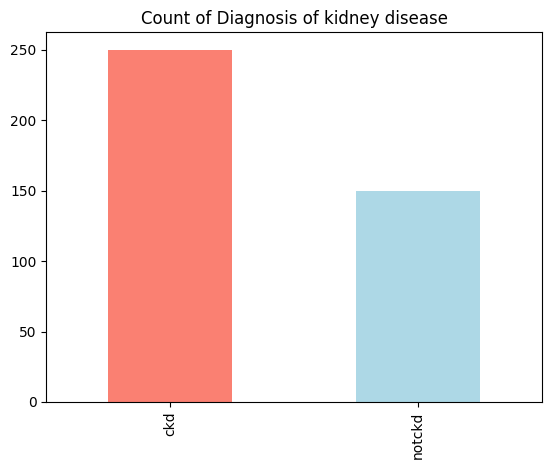

In [79]:
df['class'].value_counts().plot(kind='bar',color=['salmon','lightblue'],title="Count of Diagnosis of kidney disease")

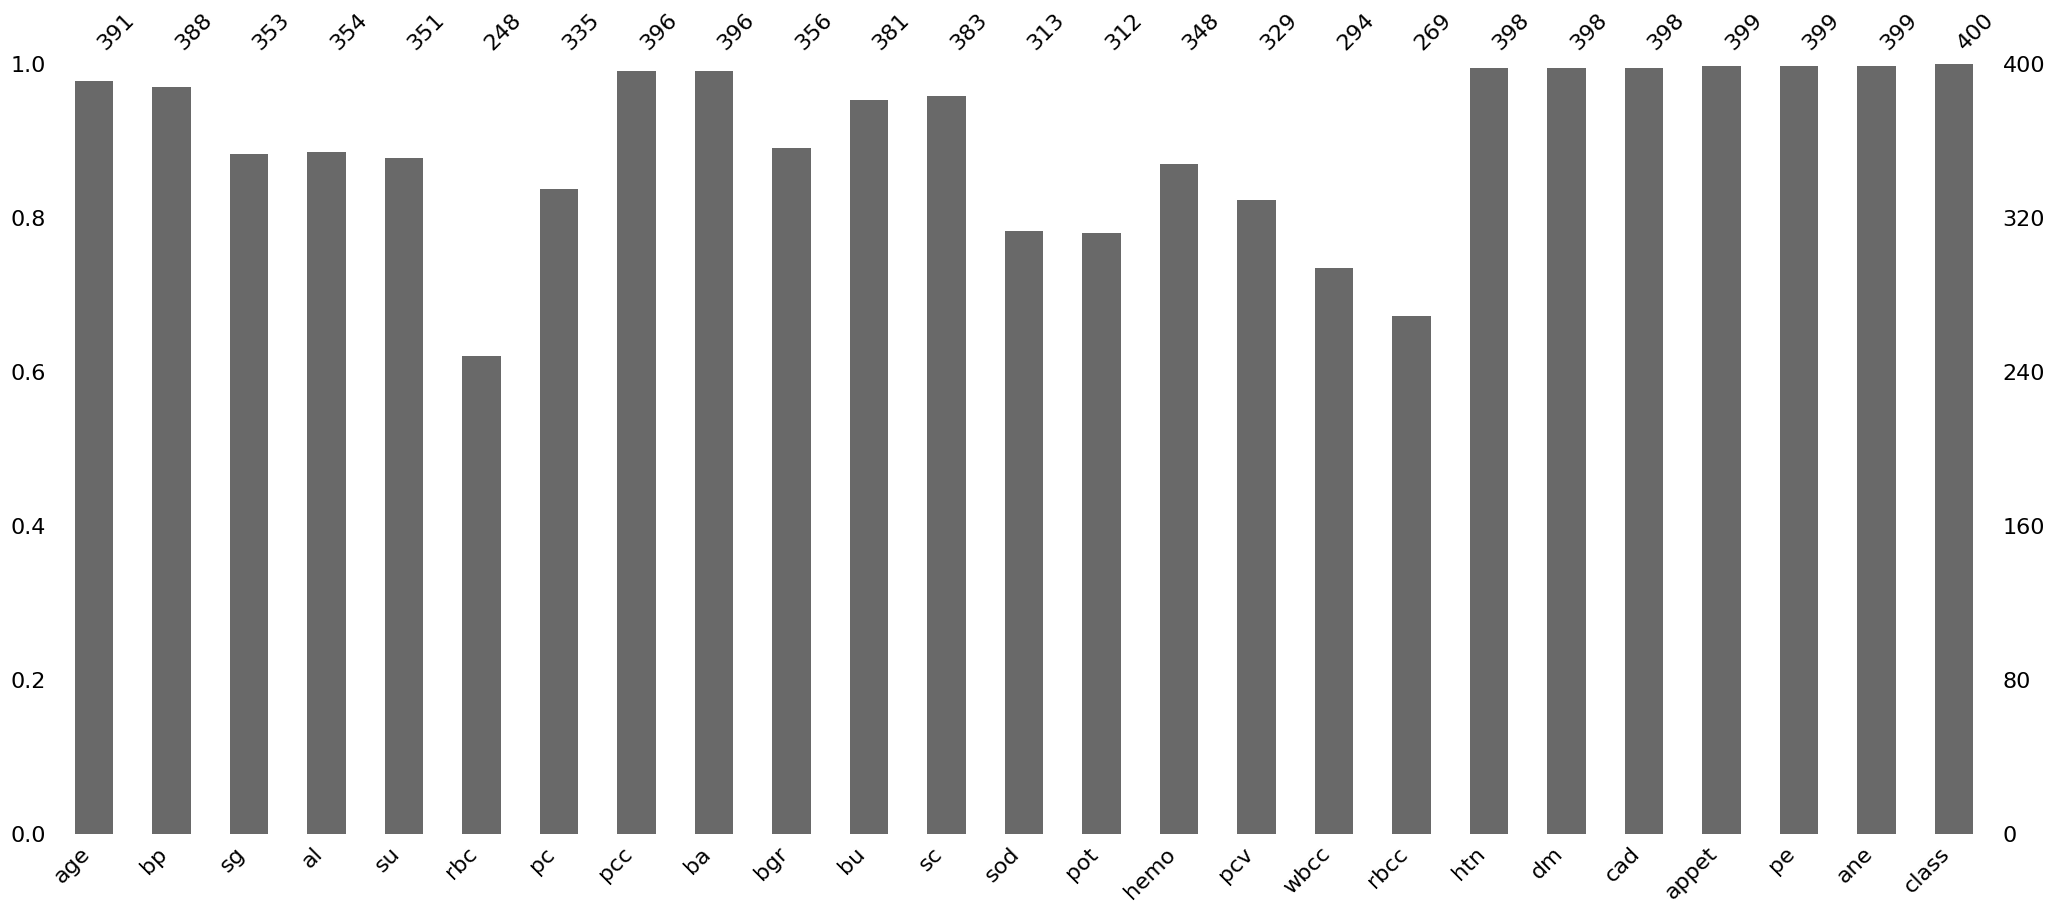

In [80]:
p = msno.bar(df)

In [81]:
df['class'] = df['class'].map({'ckd':1,'notckd':0})
df['htn'] = df['htn'].map({'yes':1,'no':0})
df['dm'] = df['dm'].map({'yes':1,'no':0})
df['cad'] = df['cad'].map({'yes':1,'no':0})
df['appet'] = df['appet'].map({'good':1,'poor':0})
df['ane'] = df['ane'].map({'yes':1,'no':0})
df['pe'] = df['pe'].map({'yes':1,'no':0})
df['ba'] = df['ba'].map({'present':1,'notpresent':0})
df['pcc'] = df['pcc'].map({'present':1,'notpresent':0})
df['pc'] = df['pc'].map({'abnormal':1,'normal':0})
df['rbc'] = df['rbc'].map({'abnormal':1,'normal':0})

<Axes: >

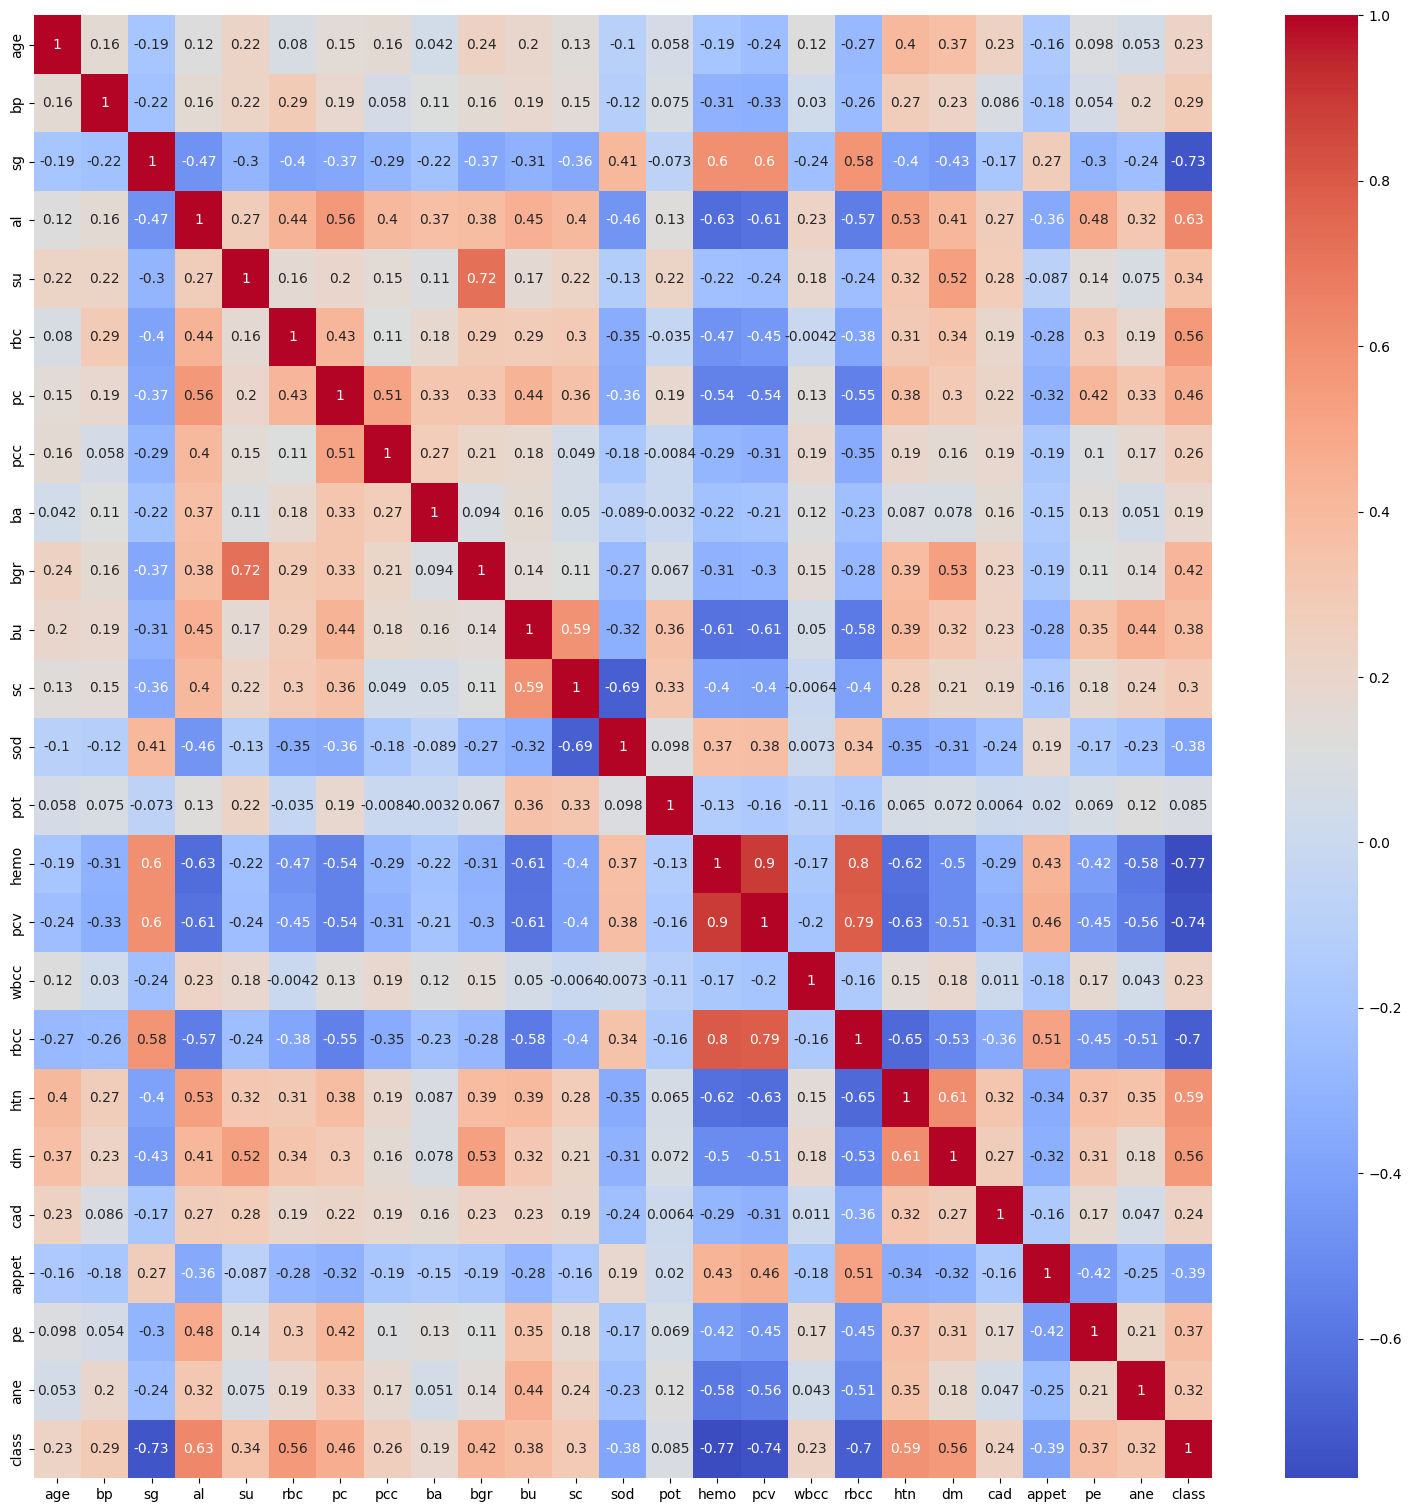

In [82]:
plt.figure(figsize = (19,19))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

In [83]:
df.shape[0], df.dropna().shape[0]

(400, 158)

In [84]:
df.dropna(inplace=True)
df.shape

(158, 25)

In [85]:
X = df.iloc[:,:-1]
y = df['class']

In [86]:
X

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
3,48.00,70.00,1.00,4.00,0.00,0.00,1.00,1.00,0.00,117.00,...,11.20,32.00,6700.00,3.90,1.00,0.00,0.00,0.00,1.00,1.00
9,53.00,90.00,1.02,2.00,0.00,1.00,1.00,1.00,0.00,70.00,...,9.50,29.00,12100.00,3.70,1.00,1.00,0.00,0.00,0.00,1.00
11,63.00,70.00,1.01,3.00,0.00,1.00,1.00,1.00,0.00,380.00,...,10.80,32.00,4500.00,3.80,1.00,1.00,0.00,0.00,1.00,0.00
14,68.00,80.00,1.01,3.00,2.00,0.00,1.00,1.00,1.00,157.00,...,5.60,16.00,11000.00,2.60,1.00,1.00,1.00,0.00,1.00,0.00
20,61.00,80.00,1.01,2.00,0.00,1.00,1.00,0.00,0.00,173.00,...,7.70,24.00,9200.00,3.20,1.00,1.00,1.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.00,80.00,1.02,0.00,0.00,0.00,0.00,0.00,0.00,140.00,...,15.70,47.00,6700.00,4.90,0.00,0.00,0.00,1.00,0.00,0.00
396,42.00,70.00,1.02,0.00,0.00,0.00,0.00,0.00,0.00,75.00,...,16.50,54.00,7800.00,6.20,0.00,0.00,0.00,1.00,0.00,0.00
397,12.00,80.00,1.02,0.00,0.00,0.00,0.00,0.00,0.00,100.00,...,15.80,49.00,6600.00,5.40,0.00,0.00,0.00,1.00,0.00,0.00
398,17.00,60.00,1.02,0.00,0.00,0.00,0.00,0.00,0.00,114.00,...,14.20,51.00,7200.00,5.90,0.00,0.00,0.00,1.00,0.00,0.00


In [87]:
y

3      1
9      1
11     1
14     1
20     1
      ..
395    0
396    0
397    0
398    0
399    0
Name: class, Length: 158, dtype: int64

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify = y,shuffle = True)

In [89]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
predictions, models = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:00<00:00, 30.07it/s]


In [90]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,1.00,1.00,1.00,1.00,0.02
BernoulliNB,1.00,1.00,1.00,1.00,0.02
SVC,1.00,1.00,1.00,1.00,0.01
SGDClassifier,1.00,1.00,1.00,1.00,0.02
ExtraTreeClassifier,1.00,1.00,1.00,1.00,0.02
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.15
GaussianNB,1.00,1.00,1.00,1.00,0.01
RidgeClassifierCV,1.00,1.00,1.00,1.00,0.02
RandomForestClassifier,1.00,1.00,1.00,1.00,0.17


In [102]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Test Accuracy: 1.0


In [106]:
best_params = {'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1}
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

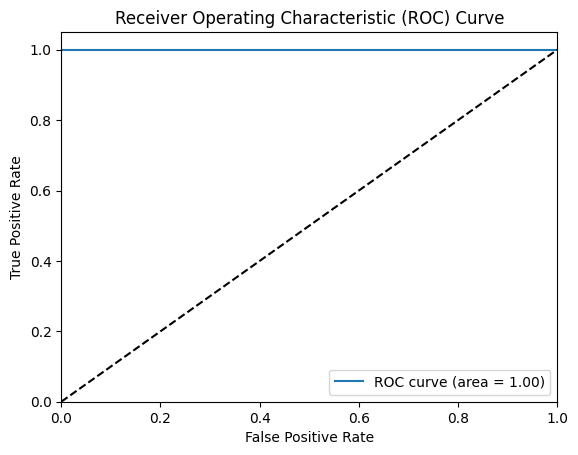

In [107]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [116]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [117]:
import pickle
saved_model = pickle.dumps(rf_clf)
rf_clf_from_pickle = pickle.loads(saved_model)
rf_clf_from_pickle.predict(X_test)

array([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0])

In [119]:
with open('kidney_disease_prediction.pkl', 'wb') as files:
    pickle.dump(logreg, files)

In [120]:
with open('kidney_disease_prediction.pkl' , 'rb') as f:
    model = pickle.load(f)

In [118]:
rf_clf.predict(X_test)

array([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0])

In [121]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
3,48.00,70.00,1.00,4.00,0.00,0.00,1.00,1.00,0.00,117.00,...,32.00,6700.00,3.90,1.00,0.00,0.00,0.00,1.00,1.00,1
9,53.00,90.00,1.02,2.00,0.00,1.00,1.00,1.00,0.00,70.00,...,29.00,12100.00,3.70,1.00,1.00,0.00,0.00,0.00,1.00,1
11,63.00,70.00,1.01,3.00,0.00,1.00,1.00,1.00,0.00,380.00,...,32.00,4500.00,3.80,1.00,1.00,0.00,0.00,1.00,0.00,1
14,68.00,80.00,1.01,3.00,2.00,0.00,1.00,1.00,1.00,157.00,...,16.00,11000.00,2.60,1.00,1.00,1.00,0.00,1.00,0.00,1
20,61.00,80.00,1.01,2.00,0.00,1.00,1.00,0.00,0.00,173.00,...,24.00,9200.00,3.20,1.00,1.00,1.00,0.00,1.00,1.00,1


In [123]:
rf_clf.predict([[48,80,1.02,1,0,1,0,1,1,2,0,0,1,1,0,1,1,2,0,0,1,0,1,2]])

array([1])